In [4]:
import kagglehub
import pandas as pd
import numpy as np
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score

c:\Users\dylan\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


We download our primary dataset, which consists of 40000 textual reviews, their corresponding ratings, and a label which lists them as either human- or computer-generated.

In [5]:
df = pd.read_csv('sample_reviews.csv')

# A. The Target Variable

We start out by examining the distribution of the target variable -- real (OR) or fake (CG).

<Axes: title={'center': 'Frequency of Labels'}, xlabel='Label', ylabel='Frequency'>

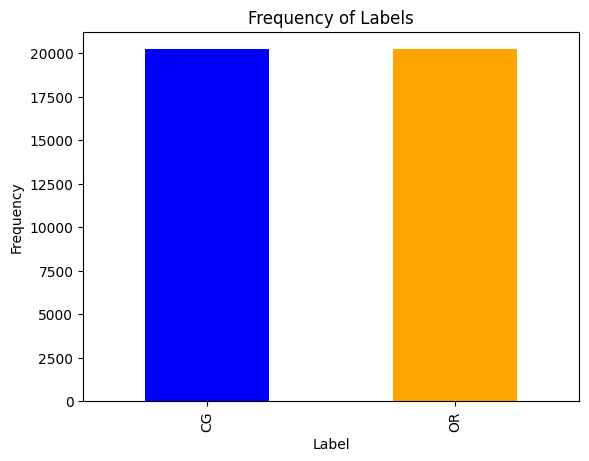

In [6]:
df['label'].value_counts().plot(kind='bar', title='Frequency of Labels', xlabel='Label', ylabel='Frequency', color=['blue', 'orange'])

In [23]:
# Encode the target variable 'label' into numerical format
df['label_encoded'] = df['label'].apply(lambda x: 1 if x == 'CG' else 0)

It turns out that they are already split quite evenly in the dataset!

# B. Classical Features

Next, we begin to explore our features. Unlike in most EDA investigations, our features are not simply given to us by the dataframe. The independent variable is a sentence rather than numerical values, so we are responsible for deriving features ourselves. Our first approach will be looking at "classical" features of the text in the same way a human might -- intuitive aspects like length, number of typos, amount of punctuation, etc.

In [7]:
fake_reviews = df[df['label'] == 'CG']
real_reviews = df[df['label'] == 'OR']

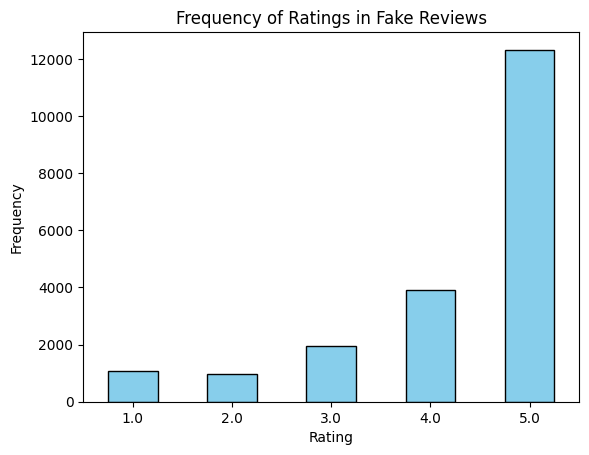

In [8]:
import matplotlib.pyplot as plt

# Count the frequency of each rating in fake_reviews
rating_counts = fake_reviews['rating'].value_counts()

# Plot the bar graph
rating_counts.sort_index().plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Frequency of Ratings in Fake Reviews')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.xticks(rotation=0)
plt.show()

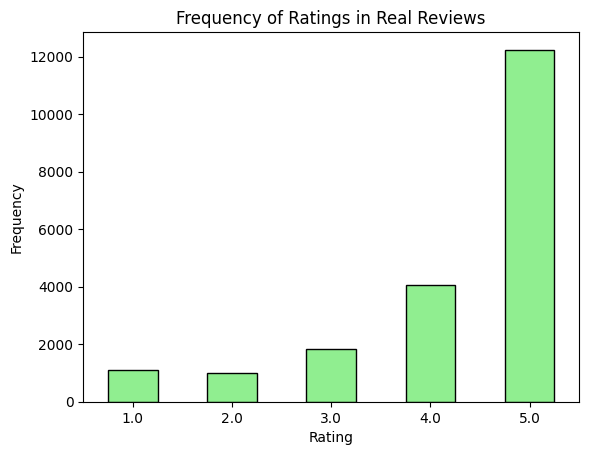

In [9]:
# Count the frequency of each rating in real_reviews
rating_counts_real = real_reviews['rating'].value_counts()

# Plot the bar graph
rating_counts_real.sort_index().plot(kind='bar', color='lightgreen', edgecolor='black')
plt.title('Frequency of Ratings in Real Reviews')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.xticks(rotation=0)
plt.show()

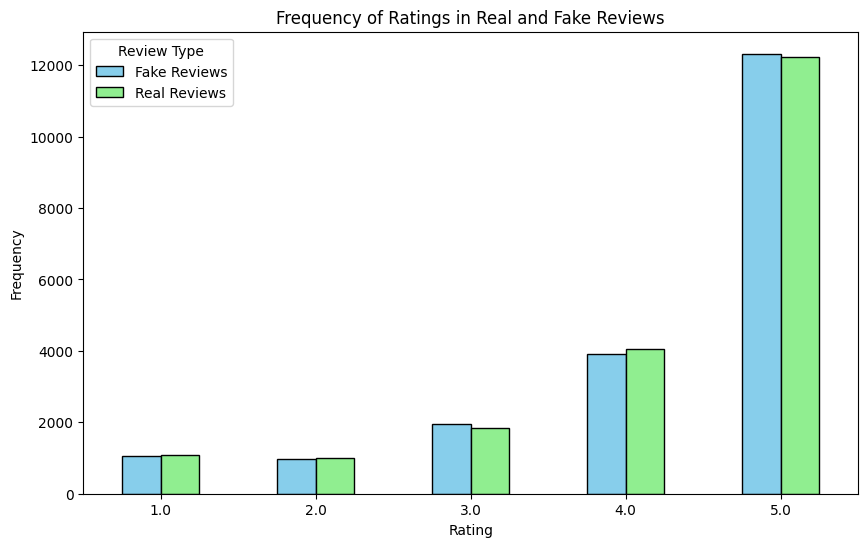

In [12]:
# Combine the rating counts for fake and real reviews
combined_rating_counts = pd.DataFrame({
	'Fake Reviews': rating_counts,
	'Real Reviews': rating_counts_real
}).fillna(0)

# Rearrange the index to go from 1.0 to 5.0
combined_rating_counts = combined_rating_counts.reindex([1.0, 2.0, 3.0, 4.0, 5.0])

# Plot the bar graph
combined_rating_counts.plot(kind='bar', color=['skyblue', 'lightgreen'], edgecolor='black', figsize=(10, 6))
plt.title('Frequency of Ratings in Real and Fake Reviews')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.xticks(rotation=0)
plt.legend(title='Review Type')
plt.show()

We first examine one feature that comes with the data already, and helps us gauge its sentiment -- the rating (on a scale of 1-5). It turns out these are stratified quite evenly between classes -- there is, perhaps surprisingly, no clear tendency for fake reviews to provide high ratings at a greater rate than real reviews. Even without this connection, we can still certainly use rating to make judgements about the text.

C:\Users\dylan\AppData\Local\Temp\ipykernel_41360\848391103.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  real_reviews['review_length'] = real_reviews['text_'].str.len()
C:\Users\dylan\AppData\Local\Temp\ipykernel_41360\848391103.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  real_reviews['length_bucket'] = pd.cut(real_reviews['review_length'], bins=bins)


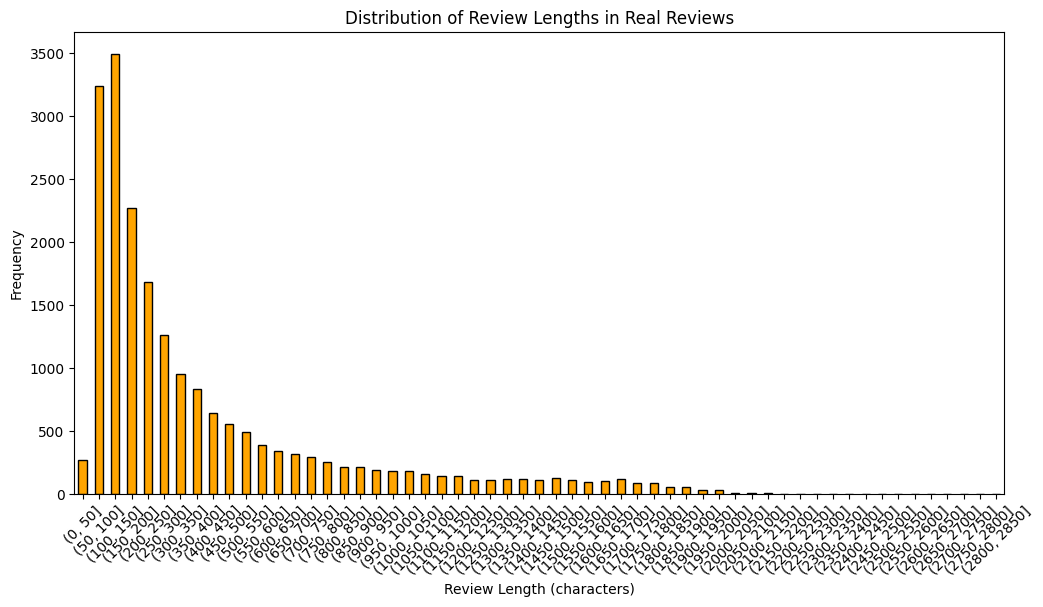

In [14]:
# Calculate the length of each review in characters
real_reviews['review_length'] = real_reviews['text_'].str.len()

# Create buckets for review lengths
bins = range(0, real_reviews['review_length'].max() + 50, 50)  # Buckets of size 50
real_reviews['length_bucket'] = pd.cut(real_reviews['review_length'], bins=bins)

# Count the frequency of each bucket
length_counts_real = real_reviews['length_bucket'].value_counts().sort_index()

# Plot the bar graph
length_counts_real.plot(kind='bar', color='orange', edgecolor='black', figsize=(12, 6))
plt.title('Distribution of Review Lengths in Real Reviews')
plt.xlabel('Review Length (characters)')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

C:\Users\dylan\AppData\Local\Temp\ipykernel_41360\1554543318.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fake_reviews['review_length'] = fake_reviews['text_'].str.len()
C:\Users\dylan\AppData\Local\Temp\ipykernel_41360\1554543318.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fake_reviews['length_bucket'] = pd.cut(fake_reviews['review_length'], bins=bins)


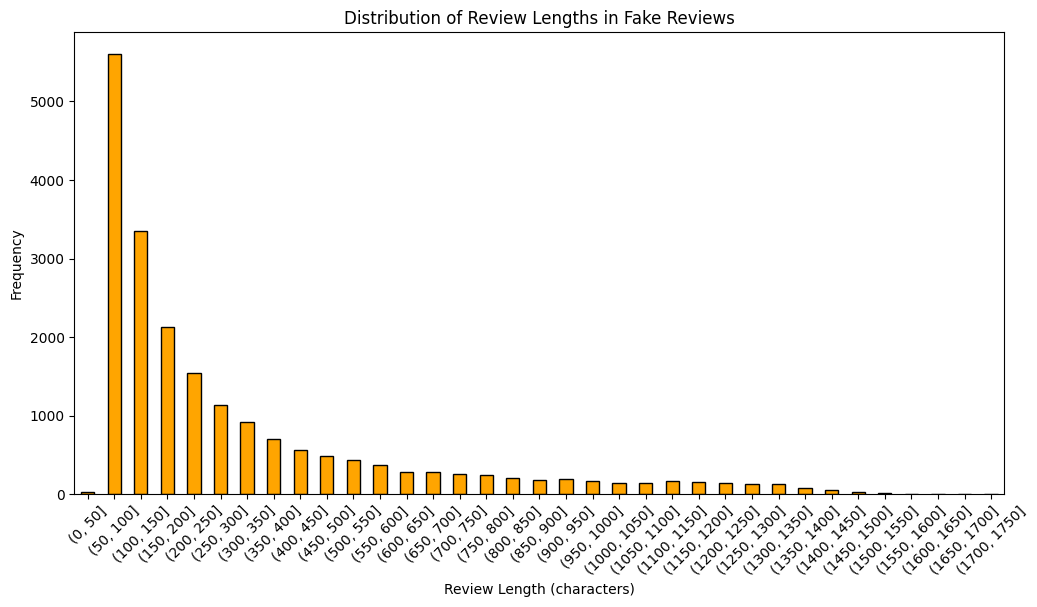

In [15]:
# Calculate the length of each review in characters
fake_reviews['review_length'] = fake_reviews['text_'].str.len()

# Create buckets for review lengths
bins = range(0, fake_reviews['review_length'].max() + 50, 50)  # Buckets of size 50
fake_reviews['length_bucket'] = pd.cut(fake_reviews['review_length'], bins=bins)

# Count the frequency of each bucket
length_counts_fake = fake_reviews['length_bucket'].value_counts().sort_index()

# Plot the bar graph
length_counts_fake.plot(kind='bar', color='orange', edgecolor='black', figsize=(12, 6))
plt.title('Distribution of Review Lengths in Fake Reviews')
plt.xlabel('Review Length (characters)')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

In [16]:
# Update the bins to include the maximum review length from both datasets
max_length = max(fake_reviews['review_length'].max(), real_reviews['review_length'].max())
bins = range(0, max_length + 50, 50)

# Recalculate the length_bucket for real_reviews using the updated bins
real_reviews['length_bucket'] = pd.cut(real_reviews['review_length'], bins=bins)

# Recalculate the frequency of each bucket for real_reviews
length_counts_real = real_reviews['length_bucket'].value_counts().sort_index()

# Update the combined_length_counts DataFrame
combined_length_counts = pd.DataFrame({
    'Fake Reviews': length_counts_fake,
    'Real Reviews': length_counts_real
}).fillna(0)

# Display the updated combined_length_counts
print(combined_length_counts)

              Fake Reviews  Real Reviews
(0, 50]               23.0           271
(50, 100]           5605.0          3236
(100, 150]          3354.0          3492
(150, 200]          2129.0          2270
(200, 250]          1547.0          1683
(250, 300]          1129.0          1262
(300, 350]           913.0           951
(350, 400]           707.0           833
(400, 450]           555.0           639
(450, 500]           488.0           552
(500, 550]           430.0           491
(550, 600]           367.0           385
(600, 650]           286.0           345
(650, 700]           286.0           321
(700, 750]           259.0           294
(750, 800]           236.0           252
(800, 850]           207.0           217
(850, 900]           173.0           217
(900, 950]           192.0           192
(950, 1000]          165.0           184
(1000, 1050]         146.0           184
(1050, 1100]         145.0           155
(1100, 1150]         162.0           143
(1150, 1200]    

C:\Users\dylan\AppData\Local\Temp\ipykernel_41360\2074632288.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  real_reviews['length_bucket'] = pd.cut(real_reviews['review_length'], bins=bins)


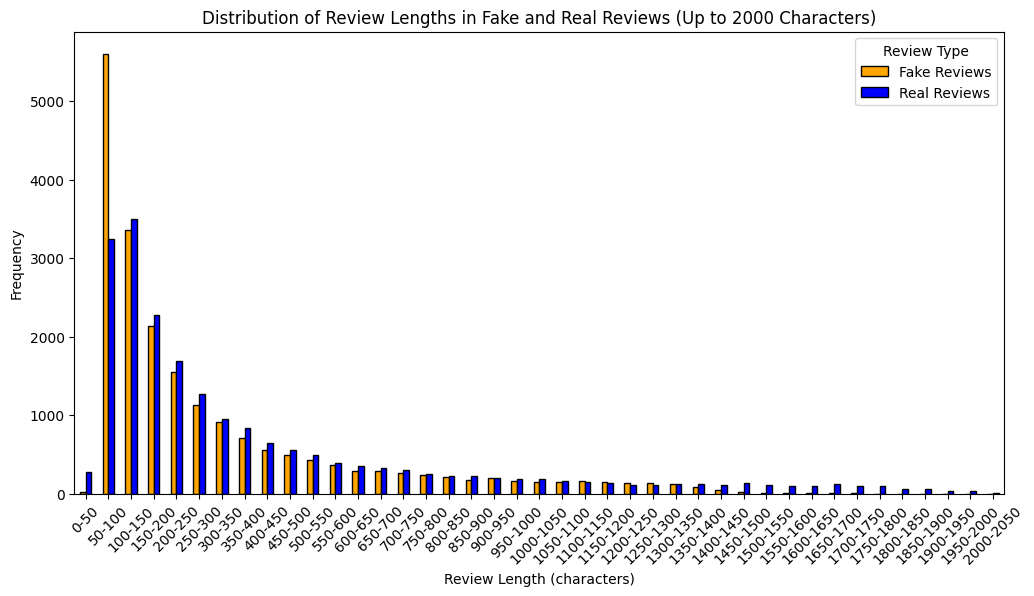

In [17]:
# Truncate the data to include only buckets up to 2000 characters
truncated_combined_length_counts = combined_length_counts.loc[:pd.Interval(2000, 2050, closed='right')]

# Plot the bar graph
truncated_combined_length_counts.plot(kind='bar', color=['orange', 'blue'], edgecolor='black', figsize=(12, 6))
plt.title('Distribution of Review Lengths in Fake and Real Reviews (Up to 2000 Characters)')
plt.xlabel('Review Length (characters)')
plt.ylabel('Frequency')

# Make x-axis labels more readable
plt.xticks(ticks=range(len(truncated_combined_length_counts.index)), 
           labels=[f'{int(interval.left)}-{int(interval.right)}' for interval in truncated_combined_length_counts.index], 
           rotation=45)

plt.legend(title='Review Type')
plt.show()

Interestingly, our study of review length unearthed a more informative trend than what we saw for ratings. It seems that fake reviews are generally shorter than real reviews, with a much larger spike in the 50-100 character range. This could be a useful factor in distinguishing the two!

In [18]:
# Compute the average length per word for fake_reviews
fake_reviews['avg_word_length'] = fake_reviews['text_'].apply(lambda x: np.mean([len(word) for word in x.split()]) if len(x.split()) > 0 else 0)

# Compute the average length per word for real_reviews
real_reviews['avg_word_length'] = real_reviews['text_'].apply(lambda x: np.mean([len(word) for word in x.split()]) if len(x.split()) > 0 else 0)

# Display the updated DataFrames
print(fake_reviews[['text_', 'avg_word_length']].head())
print(real_reviews[['text_', 'avg_word_length']].head())

C:\Users\dylan\AppData\Local\Temp\ipykernel_41360\2413125332.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fake_reviews['avg_word_length'] = fake_reviews['text_'].apply(lambda x: np.mean([len(word) for word in x.split()]) if len(x.split()) > 0 else 0)


                                               text_  avg_word_length
0  Love this!  Well made, sturdy, and very comfor...         5.166667
1  love it, a great upgrade from the original.  I...         4.000000
2  This pillow saved my back. I love the look and...         3.857143
3  Missing information on how to use it, but it i...         3.764706
4  Very nice set. Good quality. We have had the s...         3.777778
                                                text_  avg_word_length
55  These are just perfect, exactly what I was loo...              4.6
56  Such a great purchase can't beat it for the price              4.0
57  What can you say--- cheap and it works as inte...              4.2
58  These are so nice, sturdy, like the color choi...              4.5
59      It is nice bowl and have had a fast shipping!              3.6


C:\Users\dylan\AppData\Local\Temp\ipykernel_41360\2413125332.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  real_reviews['avg_word_length'] = real_reviews['text_'].apply(lambda x: np.mean([len(word) for word in x.split()]) if len(x.split()) > 0 else 0)


In [19]:
# Create bins for average word length
avg_word_length_bins = np.arange(0, max(fake_reviews['avg_word_length'].max(), real_reviews['avg_word_length'].max()) + 0.5, 0.5)

# Calculate the frequency of each bin for fake and real reviews
avg_word_length_fake_counts = pd.cut(fake_reviews['avg_word_length'], bins=avg_word_length_bins).value_counts().sort_index()
avg_word_length_real_counts = pd.cut(real_reviews['avg_word_length'], bins=avg_word_length_bins).value_counts().sort_index()

# Combine the counts into a single DataFrame
combined_avg_word_length_counts = pd.DataFrame({
    'Fake Reviews': avg_word_length_fake_counts,
    'Real Reviews': avg_word_length_real_counts
}).fillna(0)


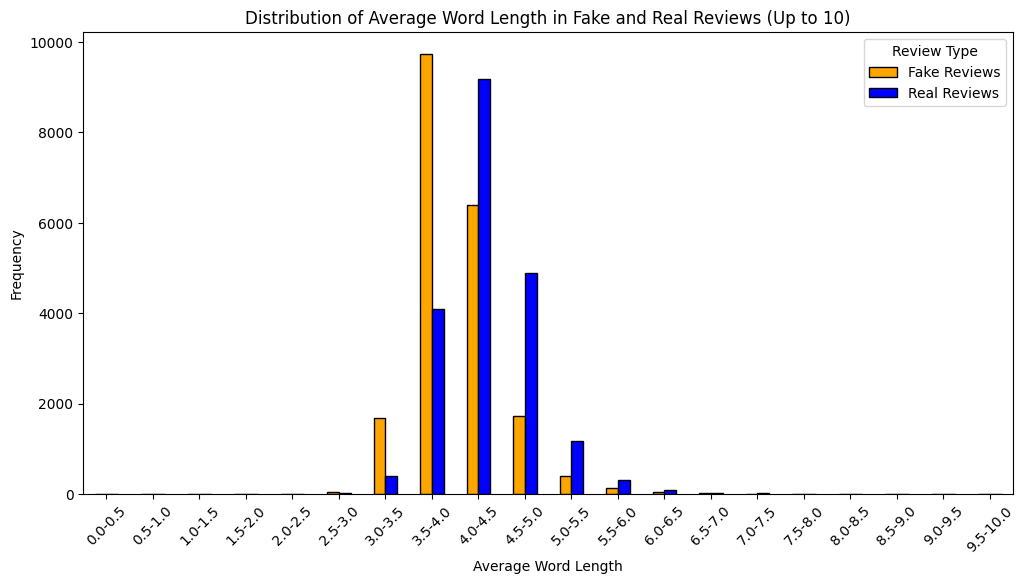

In [20]:
# Filter the combined_avg_word_length_counts to include only buckets up to 10
filtered_combined_avg_word_length_counts = combined_avg_word_length_counts.loc[
    combined_avg_word_length_counts.index.map(lambda x: x.right <= 10)
]

# Plot the filtered histogram
filtered_combined_avg_word_length_counts.plot(kind='bar', color=['orange', 'blue'], edgecolor='black', figsize=(12, 6))
plt.title('Distribution of Average Word Length in Fake and Real Reviews (Up to 10)')
plt.xlabel('Average Word Length')
plt.ylabel('Frequency')

# Make x-axis labels more readable
plt.xticks(ticks=range(len(filtered_combined_avg_word_length_counts.index)), 
           labels=[f'{interval.left:.1f}-{interval.right:.1f}' for interval in filtered_combined_avg_word_length_counts.index], 
           rotation=45)

plt.legend(title='Review Type')
plt.show()

We also thought it would be useful to investigate the average length of a word in each review. That is, reviews with more complex -- and thus longer -- words will have a higher avg_word_length. We see that this metric is also quite a bit higher for real reviews than fake, implying real reviews use more complex and longer words than fake, a useful fact to keep in mind.

In [ ]:
import string
import enchant
# Initialize the English dictionary
dictionary = enchant.Dict("en_US")

# Function to count typos in a review
def count_typos(review):
    # Remove punctuation and split into words
    words = review.translate(str.maketrans('', '', string.punctuation)).split()
    # Count words that are not in the dictionary
    return sum(1 for word in words if not dictionary.check(word))

# Add a column for the number of typos in each review for both fake_reviews and real_reviews
fake_reviews['typo_count'] = fake_reviews['text_'].apply(count_typos)
real_reviews['typo_count'] = real_reviews['text_'].apply(count_typos)

# Display the updated DataFrames
print(fake_reviews[['text_', 'typo_count']].head())
print(real_reviews[['text_', 'typo_count']].head())

In [11]:
print(real_reviews['typo_count'].describe())
print(fake_reviews['typo_count'].describe())

count    20216.000000
mean         2.141373
std          3.376410
min          0.000000
25%          0.000000
50%          1.000000
75%          3.000000
max         48.000000
Name: typo_count, dtype: float64
count    20216.000000
mean         1.440394
std          2.424442
min          0.000000
25%          0.000000
50%          1.000000
75%          2.000000
max         54.000000
Name: typo_count, dtype: float64


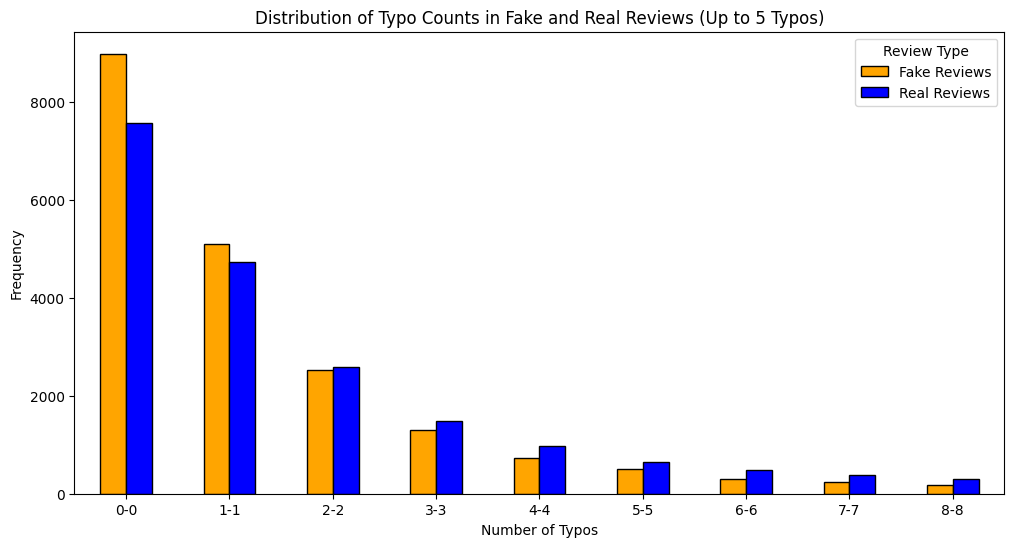

In [14]:

import matplotlib.pyplot as plt
# Create bins for typo_count, truncated to a maximum of 5
typo_count_bins = range(0, 10)

# Calculate the frequency of each bin for fake and real reviews
typo_count_fake_counts = pd.cut(fake_reviews['typo_count'], bins=typo_count_bins, right=False).value_counts().sort_index()
typo_count_real_counts = pd.cut(real_reviews['typo_count'], bins=typo_count_bins, right=False).value_counts().sort_index()

# Combine the counts into a single DataFrame
combined_typo_count_counts = pd.DataFrame({
    'Fake Reviews': typo_count_fake_counts,
    'Real Reviews': typo_count_real_counts
}).fillna(0)

# Plot the histogram
combined_typo_count_counts.plot(kind='bar', color=['orange', 'blue'], edgecolor='black', figsize=(12, 6))
plt.title('Distribution of Typo Counts in Fake and Real Reviews (Up to 5 Typos)')
plt.xlabel('Number of Typos')
plt.ylabel('Frequency')

# Make x-axis labels more readable
plt.xticks(ticks=range(len(combined_typo_count_counts.index)), 
           labels=[f'{int(interval.left)}-{int(interval.right)-1}' for interval in combined_typo_count_counts.index], 
           rotation=0)

plt.legend(title='Review Type')
plt.show()

We used Python's enchant library to find the number of typos in each review with respect to a broader English corpus. It's clear from the above graph that fake reviews tend to have slightly fewer typos than real reviews. This might seem surprising given the reputation of bot reviews as typo-ridden, but for any sufficiently well-written bot it makes sense -- a computer should rarely make typos, while a human can make them often.

In [ ]:
# Function to count punctuation characters in a review
def count_punctuation(review):
    return sum(1 for char in review if char in string.punctuation)

# Add a column for the number of punctuation characters in each review for both fabke_reviews and real_reviews
fake_reviews['punctuation_count'] = fake_reviews['text_'].apply(count_punctuation)
real_reviews['punctuation_count'] = real_reviews['text_'].apply(count_punctuation)

# Display the updated DataFrames
print(fake_reviews[['text_', 'punctuation_count']].head())
print(real_reviews[['text_', 'punctuation_count']].head())

C:\Users\dylan\AppData\Local\Temp\ipykernel_25436\2172945002.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fake_reviews['punctuation_count'] = fake_reviews['text_'].apply(count_punctuation)


                                               text_  punctuation_count
0  Love this!  Well made, sturdy, and very comfor...                  5
1  love it, a great upgrade from the original.  I...                  3
2  This pillow saved my back. I love the look and...                  2
3  Missing information on how to use it, but it i...                  2
4  Very nice set. Good quality. We have had the s...                  2
                                                text_  punctuation_count
55  These are just perfect, exactly what I was loo...                  2
56  Such a great purchase can't beat it for the price                  1
57  What can you say--- cheap and it works as inte...                  4
58  These are so nice, sturdy, like the color choi...                  3
59      It is nice bowl and have had a fast shipping!                  1


C:\Users\dylan\AppData\Local\Temp\ipykernel_25436\2172945002.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  real_reviews['punctuation_count'] = real_reviews['text_'].apply(count_punctuation)


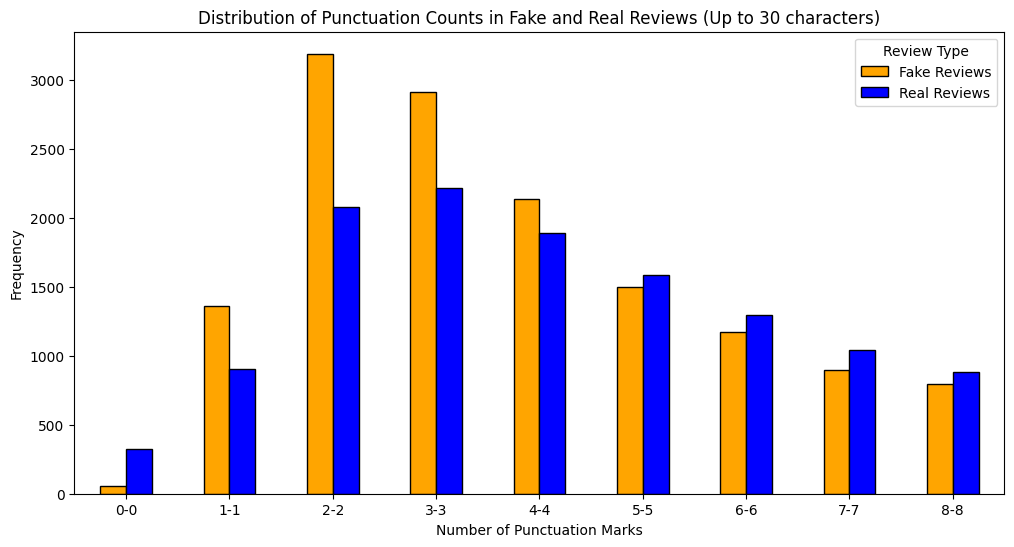

In [20]:

import matplotlib.pyplot as plt
# Create bins for typo_count, truncated to a maximum of 5
punc_bins = range(0, 30)

# Calculate the frequency of each bin for fake and real reviews
punc_fake_counts = pd.cut(fake_reviews['punctuation_count'], bins=typo_count_bins, right=False).value_counts().sort_index()
punc_real_counts = pd.cut(real_reviews['punctuation_count'], bins=typo_count_bins, right=False).value_counts().sort_index()

# Combine the counts into a single DataFrame
combined_punc_counts = pd.DataFrame({
    'Fake Reviews': punc_fake_counts,
    'Real Reviews': punc_real_counts
}).fillna(0)

# Plot the histogram
combined_punc_counts.plot(kind='bar', color=['orange', 'blue'], edgecolor='black', figsize=(12, 6))
plt.title('Distribution of Punctuation Counts in Fake and Real Reviews (Up to 30 characters)')
plt.xlabel('Number of Punctuation Marks')
plt.ylabel('Frequency')

# Make x-axis labels more readable
plt.xticks(ticks=range(len(combined_punc_counts.index)), 
           labels=[f'{int(interval.left)}-{int(interval.right)-1}' for interval in combined_punc_counts.index], 
           rotation=0)

plt.legend(title='Review Type')
plt.show()

Lastly, I looked into the number of punctuation marks in each review, figuring that bot reviews tend to have run-on sentences and thus less punctuation. Indeed, the above graph shows that bot reviews concentrate around only a few punctuation marks, while real reviews are less concentrated and tend to have a few more.

In [24]:
# Add the numerical columns back to the original df
df['typo_count'] = df['text_'].apply(count_typos)
df['punctuation_count'] = df['text_'].apply(count_punctuation)
df['avg_word_length'] = df['text_'].apply(lambda x: np.mean([len(word) for word in x.split()]) if len(x.split()) > 0 else 0)
df['review_length'] = df['text_'].str.len()

# Display the updated DataFrame
print(df[['text_', 'typo_count', 'punctuation_count', 'avg_word_length', 'review_length']].head())

                                               text_  typo_count  \
0  Love this!  Well made, sturdy, and very comfor...           1   
1  love it, a great upgrade from the original.  I...           1   
2  This pillow saved my back. I love the look and...           0   
3  Missing information on how to use it, but it i...           0   
4  Very nice set. Good quality. We have had the s...           0   

   punctuation_count  avg_word_length  review_length  
0                  5         5.166667             75  
1                  3         4.000000             80  
2                  2         3.857143             67  
3                  2         3.764706             81  
4                  2         3.777778             85  


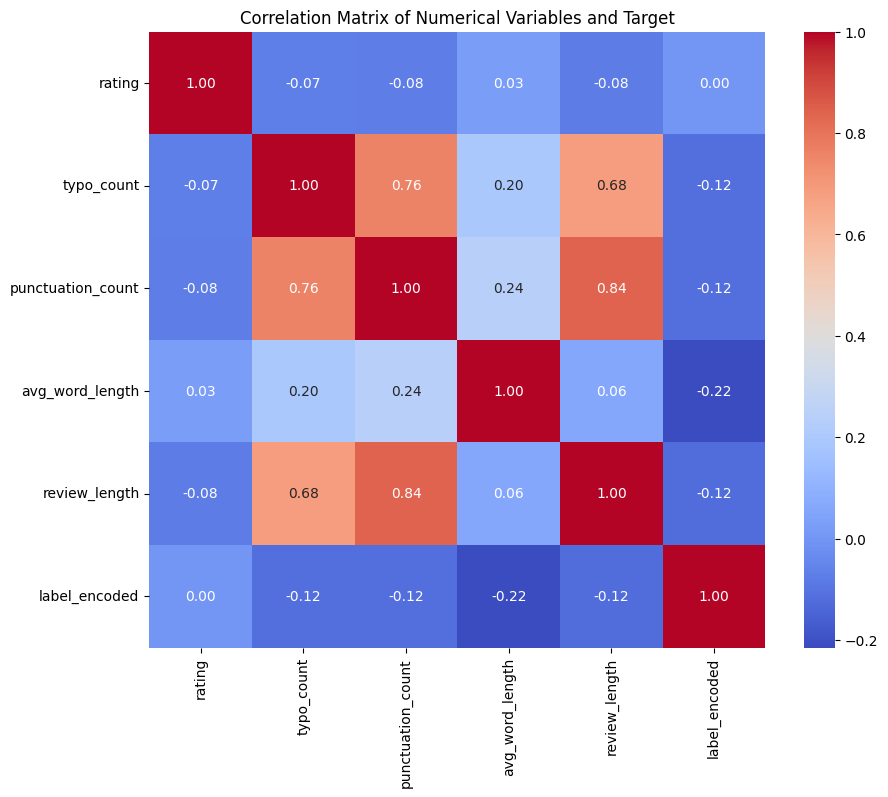

In [ ]:
import seaborn as sns



# Select the relevant columns for correlation
correlation_data = df[['rating', 'typo_count', 'punctuation_count', 'avg_word_length', 'review_length', 'label_encoded']]

# Compute the correlation matrix
correlation_matrix = correlation_data.corr()

# Plot the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', square=True)
plt.title('Correlation Matrix of Numerical Variables and Target')
plt.show()

With these 5 numerical features derived from our dataset, we are able to plot the typical correlation matrix. It shows that while a few of the features are heavily correlated to each other (review length and punctuation count, for instance), none are heavily correlated to the fake/real label. The most correlated is avg_word_length, with a negative correlation implying that as the average word length increases, the label is more likely to be a 0 (real review). Most of the correlations seem to be of around the same magnitude, meaning we would benefit from using all the features in our model, perhaps with the exception of rating.

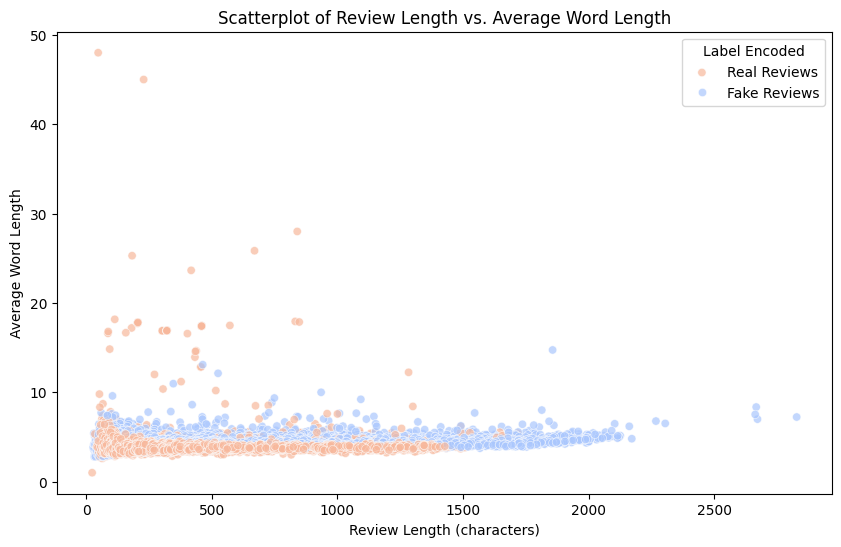

In [31]:
# Scatterplot of review length vs. average word length, colored by label_encoded
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='review_length', y='avg_word_length', hue='label_encoded', palette='coolwarm', alpha=0.7)
plt.title('Scatterplot of Review Length vs. Average Word Length')
plt.xlabel('Review Length (characters)')
plt.ylabel('Average Word Length')
plt.legend(title='Label Encoded', labels=['Real Reviews', 'Fake Reviews'])
plt.show()

We tried out a few scatterplots to see if two of the features could be used to visually distinguish between real and fake reviews. The best we could do was average word length and review length, which, when combined, do show two pretty different sets for real and fake reviews, with the real reviews having reduced review length and higher average word lengths. But it's a weak clustering at best, and not particularly convincing. We will definitely train some models with these features, but we also can tell that this kind of rough classical feature selection is just the tip of the iceberg when it comes to analyzing textual data.

# C. Bag-of-Words

As we've learned in our NLP class, a more popular way to approach text data is by encoding all the words into some compact representation, rather than just picking out basic facts like the length and punctuation count. One of the more basic ways to do this is through Bag of Words -- essentially, representing each review by the frequency of the words that appear in it.

In [34]:
# Function to clean text
def clean_text(text):
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove punctuation
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
    return text.lower()  # Convert to lowercase

In [ ]:
# Clean text_
df["text_"] = df["text_"].astype(str).apply(clean_text)

# Extract features and label_encoded
X = df["text_"]
y = df["label_encoded"]

# Convert text data into bag-of-words features
vectorizer = CountVectorizer()
X_bow = vectorizer.fit_transform(X)


In [ ]:
word_counts = X_bow.toarray().sum(axis=0)
word_freq = dict(zip(vectorizer.get_feature_names_out(), word_counts))
sorted_words = sorted(word_freq.items(), key=lambda x: x[1], reverse=True)
print(sorted_words[:20])  # Top 20 most frequent words

[('the', np.int64(157436)), ('and', np.int64(87622)), ('it', np.int64(68626)), ('to', np.int64(68542)), ('is', np.int64(64804)), ('this', np.int64(49183)), ('of', np.int64(45553)), ('for', np.int64(38930)), ('in', np.int64(29623)), ('that', np.int64(26662)), ('was', np.int64(26299)), ('my', np.int64(24671)), ('with', np.int64(23655)), ('have', np.int64(23213)), ('very', np.int64(20710)), ('but', np.int64(20572)), ('not', np.int64(19310)), ('are', np.int64(19118)), ('great', np.int64(16419)), ('on', np.int64(16270))]


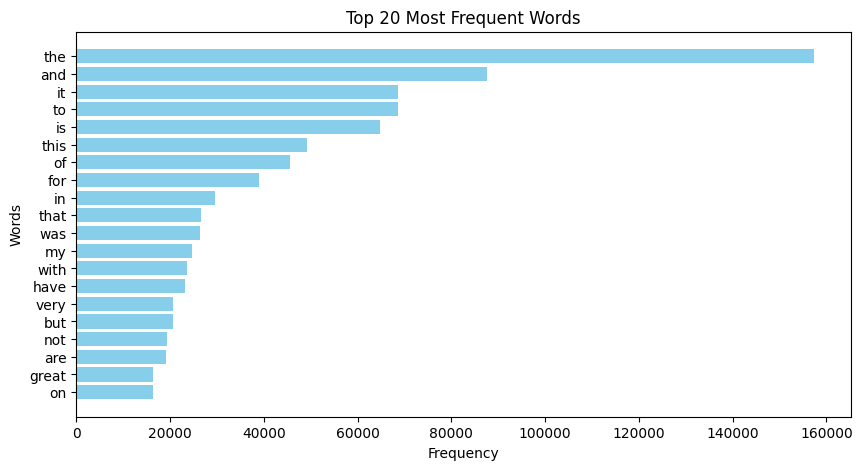

In [43]:
top_words, top_counts = zip(*sorted_words[:20])
plt.figure(figsize=(10, 5))
plt.barh(top_words, top_counts, color='skyblue')
plt.gca().invert_yaxis()  # Highest at top
plt.xlabel("Frequency")
plt.ylabel("Words")
plt.title("Top 20 Most Frequent Words")
plt.show()

While Bag of Words representations can't exactly be analyzed in the same way as typical features, one way we thought of exploring them was to look at which words were most frequent. Simply converting all reviews to BOW format shows the above top 20 words.

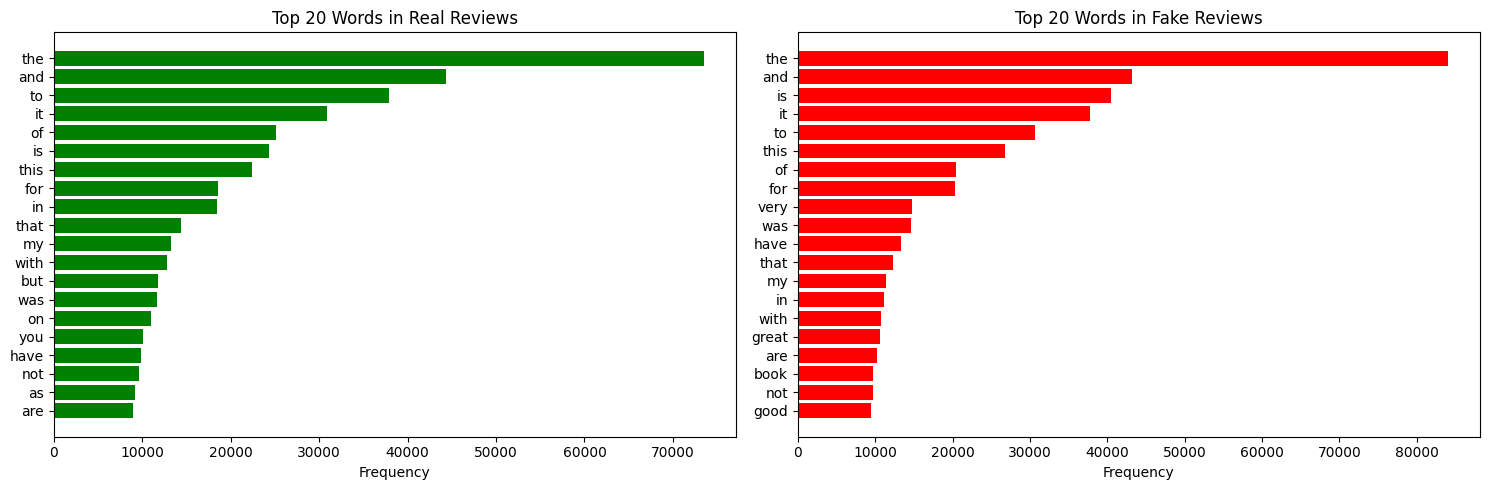

In [ ]:
real_reviews = df[df["label_encoded"] == 0]["text_"]
fake_reviews = df[df["label_encoded"] == 1]["text_"]

vectorizer_real = CountVectorizer()
vectorizer_fake = CountVectorizer()
X_real_bow = vectorizer_real.fit_transform(real_reviews)
X_fake_bow = vectorizer_fake.fit_transform(fake_reviews)

# Get word frequency distributions
word_counts_real = X_real_bow.toarray().sum(axis=0)
word_counts_fake = X_fake_bow.toarray().sum(axis=0)

word_freq_real = dict(zip(vectorizer_real.get_feature_names_out(), word_counts_real))
word_freq_fake = dict(zip(vectorizer_fake.get_feature_names_out(), word_counts_fake))

sorted_real = sorted(word_freq_real.items(), key=lambda x: x[1], reverse=True)[:20]
sorted_fake = sorted(word_freq_fake.items(), key=lambda x: x[1], reverse=True)[:20]

# Plot separate bar charts
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Real reviews
real_words, real_counts = zip(*sorted_real)
axes[0].barh(real_words, real_counts, color='green')
axes[0].invert_yaxis()
axes[0].set_title("Top 20 Words in Real Reviews")
axes[0].set_xlabel("Frequency")

# Fake reviews
fake_words, fake_counts = zip(*sorted_fake)
axes[1].barh(fake_words, fake_counts, color='red')
axes[1].invert_yaxis()
axes[1].set_title("Top 20 Words in Fake Reviews")
axes[1].set_xlabel("Frequency")

plt.tight_layout()
plt.show()


Meanwhile, when we segment into real and fake reviews, we see slight deviations. Real reviews tend to have more prepositions and filler words, while fake reviews tend to have more strong adjectives and adverbs -- "very", "great", "good" -- that would be useful for convincing people to buy a product or go to a restaurant. This difference supports our hypothesis that a bag-of-words model might be effective, but it is still quite slight, so hard to say how effective the model will be.

# D. Embeddings

Of course, no toolkit of text preprocessing would be complete without embeddings. Instead of converting a sentence to a dict of its word frequencies, embeddings convert each word to a high-dimensional vector and concatenate them, maintaining the order of the words and not just their frequency, at the expense of some additional complexity.

In [3]:
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess

In [26]:
from gensim.downloader import load

word2vec_model = load("word2vec-google-news-300")  # This handles download & loading for you

[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [ ]:
from gensim.models import KeyedVectors
from gensim.utils import simple_preprocess
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Function to clean and tokenize text
def clean_and_tokenize(text):
    return simple_preprocess(text)  # Tokenizes, lowercases, removes punctuations



# Tokenize text_
df["text_processed"] = df["text_"].astype(str).apply(clean_and_tokenize)

# Function to get sentence embeddings by averaging word vectors
def get_sentence_embedding(tokens):
    vectors = [word2vec_model[word] for word in tokens if word in word2vec_model]
    return np.mean(vectors, axis=0) if vectors else np.zeros(word2vec_model.vector_size)

# Compute embeddings
X_embeddings = np.array(df["text_processed"].apply(get_sentence_embedding).tolist())

# Extract labels
y = df["label_encoded"]

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X_embeddings, y, test_size=0.2, random_state=42)

# Reduce dimensionality with PCA for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_embeddings)




In [30]:
print(X_embeddings.shape)

(40432, 300)


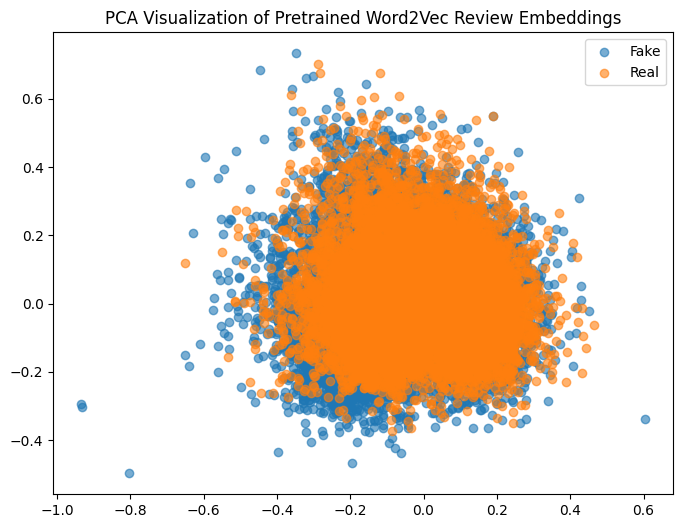

cluster           0      1
label_encoded             
0              6730  13486
1              7451  12765


In [31]:
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[df["label_encoded"] == 1, 0], X_pca[df["label_encoded"] == 1, 1], label="Fake", alpha=0.6)
plt.scatter(X_pca[df["label_encoded"] == 0, 0], X_pca[df["label_encoded"] == 0, 1], label="Real", alpha=0.6)
plt.legend()
plt.title("PCA Visualization of Pretrained Word2Vec Review Embeddings")
plt.show()

# Cluster embeddings using K-Means
kmeans = KMeans(n_clusters=2, random_state=42)
df["cluster"] = kmeans.fit_predict(X_embeddings)

# Compare clustering with labels
print(pd.crosstab(df["label_encoded"], df["cluster"]))

Using the common embedding scheme of Word2Vec, pre-trained on a broad Google corpus, we obtain 300-dimensional vectors for each review. These obviously can't be explored easily due to their high dimension, so we used PCA to project them down into just the two most salient dimensions. Interestingly, we see the formation of two pretty distinct clusters from this perspective. The real reviews clearly form a less broadly-distributed cluster in the center, while the bot reviews expand outside of it. Perhaps with higher dimensionality, the clusters could be coerced to separate further, but it's already a good hint that embeddings could provide a lot of information for distinguishing between the groups. Unfortunately, it's hard to intuit exactly WHAT is so different between the two sets, since we don't know what these basis vectors in the PCA represent, so we may look more into making this representation explainable. It also should be noted that for convenience sake, we simply averaged  the word embeddings to form the review embedding -- a better approach may be to use some sort of self-attention to weight them, which we will consider when writing our model.